# Multi-class classification based on Softmax and Cross-Entropy using pytorch

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [2]:
directory_data  = './data/'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [3]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## hyper-parameters

In [4]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 100
size_minibatch  = 40
learning_rate   = 0.01
weight_decay    = 0.001

## custom data loader for the PyTorch framework

In [5]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(np.long)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels
        

## construct datasets and dataloaders for training and testing

In [6]:
dataset_train   = dataset(x_train, y_train)
dataset_test    = dataset(x_test, y_test)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_train.collate_fn)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_test.collate_fn)

## shape of the data when using the data loader

In [7]:
image, label    = next(iter(dataloader_train))
print('************************************************************')
print('size of mini-batch of the image:', image.shape)
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([40, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([40])
************************************************************


## class for the neural network 

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.feature    = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4, stride=1, padding=2, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=4, stride=1, padding=2, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            # nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(2048, 10, bias=True)
        )

        self.network    = nn.Sequential(
            self.feature,
            nn.Flatten(),
            self.classifier,
        )

        self.initialize()


    def initialize(self):

        for m in self.network.modules():

            if isinstance(m, nn.Conv2d):

                nn.init.constant_(m.weight, 0.01)
                nn.init.constant_(m.bias, 1)

            elif isinstance(m, nn.Linear):

                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 1)


    def forward(self, input):

        output = self.network(input)

        return output

    

## build network

In [9]:
classifier  = Classifier().to(device)
optimizer   = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

## print the defined neural network

In [10]:
print(classifier)

Classifier(
  (feature): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=10, bias=True)
  )
  (network): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): Conv2d(8, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReLU()
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Sequential(
      (0): Linear(in_features=2048, out_feat

## compute the prediction

In [11]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [12]:
def compute_loss(prediction, label):

    criterion   = nn.CrossEntropyLoss()
    loss        = criterion(prediction, label)
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [13]:
def compute_accuracy(prediction, label):
    # ================================================================================ 
    # complete the function body 
    
    
    bCorrect = prediction.argmax(axis=1) == label
    accuracy = (torch.sum(bCorrect) / len(label)).detach().cpu().numpy()
    # ================================================================================ 

    return accuracy

## variables for the learning curve

In [14]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train and test

In [15]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    classifier.train()

    for index_batch, (image_train, label_train) in enumerate(dataloader_train):

        image_train = image_train.to(device)
        label_train = label_train.to(device)
        prediction_train                = compute_prediction(classifier, image_train)
        loss_train, loss_value_train    = compute_loss(prediction_train, label_train)
        accuracy_train                  = compute_accuracy(prediction_train, label_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss_train_epoch.append(loss_value_train)
        accuracy_train_epoch.append(accuracy_train)

    loss_mean_train[i]      = np.mean(loss_train_epoch)
    loss_std_train[i]       = np.std(loss_train_epoch)

    accuracy_mean_train[i]  = np.mean(accuracy_train_epoch)
    accuracy_std_train[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []

    classifier.train()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):

        image_test = image_test.to(device)
        label_test = label_test.to(device)
        
        prediction_test             = compute_prediction(classifier, image_test)
        loss_test, loss_value_test  = compute_loss(prediction_test, label_test)
        accuracy_test               = compute_accuracy(prediction_test, label_test)

        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_mean_test[i]      = np.mean(loss_test_epoch)
    loss_std_test[i]       = np.std(loss_test_epoch)

    accuracy_mean_test[i]  = np.mean(accuracy_test)
    accuracy_std_test[i]   = np.std(accuracy_test)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 100/100 [03:31<00:00,  2.11s/it]


## plot curve

In [16]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [17]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [18]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [19]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [20]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [21]:
def function_result_01():

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [22]:
def function_result_02():

    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [23]:
def function_result_03():
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [24]:
def function_result_04():
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [25]:
def function_result_05():
    
    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [26]:
def function_result_06():
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [27]:
def function_result_07():
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [28]:
def function_result_08():
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [29]:
def function_result_09():
    
    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [30]:
def function_result_10():
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---

## # 01. plot the training loss curve (mean, std)

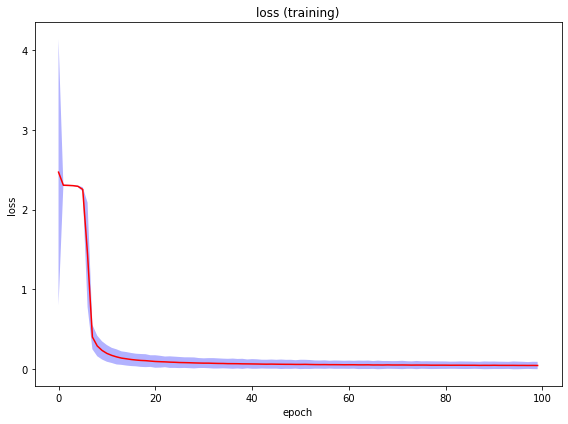

In [31]:
function_result_01()

## # 02. plot the training accuracy curve (mean, std)

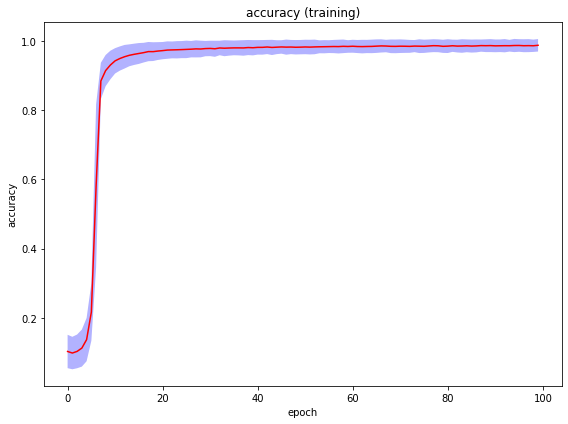

In [32]:
function_result_02()

## # 03. plot the testing loss curve (mean, std)

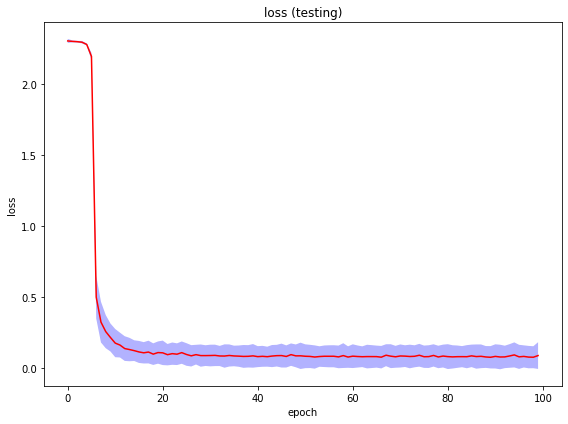

In [33]:
function_result_03()

## # 04. plot the testing accuracy curve (mean, std)

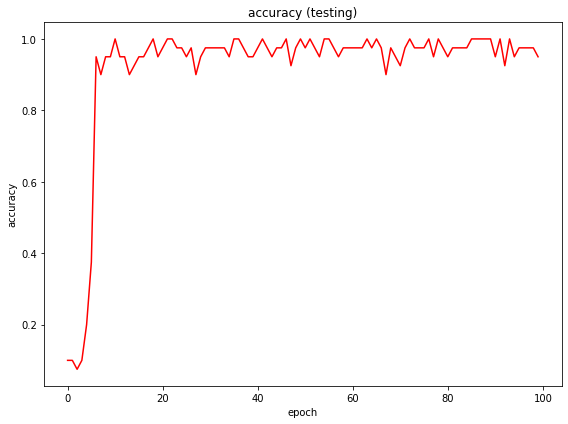

In [34]:
function_result_04()

## # 05. print the training (mean) loss over batches at last 10 epochs

In [35]:
function_result_05()

index =  0, value = 0.0444607627
index =  1, value = 0.0432331639
index =  2, value = 0.0431406365
index =  3, value = 0.0430049957
index =  4, value = 0.0431868137
index =  5, value = 0.0423162009
index =  6, value = 0.0425114133
index =  7, value = 0.0417628298
index =  8, value = 0.0422701912
index =  9, value = 0.0415092246


## # 06. print the training (mean) accuracy over batches at last 10 epochs

In [36]:
function_result_06()

index =  0, value = 0.9861500263
index =  1, value = 0.9864000082
index =  2, value = 0.9865999818
index =  3, value = 0.9865000248
index =  4, value = 0.9871000051
index =  5, value = 0.9872000217
index =  6, value = 0.9865000248
index =  7, value = 0.9867500067
index =  8, value = 0.9864000082
index =  9, value = 0.9877499938


## # 07. print the testing (mean) loss over batches at last 10 epochs

In [37]:
function_result_07()

index =  0, value = 0.0846689344
index =  1, value = 0.0804116474
index =  2, value = 0.0810478335
index =  3, value = 0.0876701172
index =  4, value = 0.0951658040
index =  5, value = 0.0815494913
index =  6, value = 0.0845017539
index =  7, value = 0.0797479571
index =  8, value = 0.0788282161
index =  9, value = 0.0905060715


## # 08. print the testing (mean) accuracy over batches at last 10 epochs

In [38]:
function_result_08()

index =  0, value = 0.9499999881
index =  1, value = 1.0000000000
index =  2, value = 0.9250000119
index =  3, value = 1.0000000000
index =  4, value = 0.9499999881
index =  5, value = 0.9750000238
index =  6, value = 0.9750000238
index =  7, value = 0.9750000238
index =  8, value = 0.9750000238
index =  9, value = 0.9499999881


## # 09. print the best training (mean) accuracy within the last 10 epochs

In [39]:
function_result_09()

best training accuracy = 0.9877499938


## # 10. print the best testing (mean) accuracy within the last 10 epochs

In [40]:
function_result_10()

best testing accuracy = 1.0000000000
